In [114]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
from io import BytesIO
from functools import partial
import keras
import keras.backend as K
import PIL.Image
import keras.layers
from IPython.display import clear_output

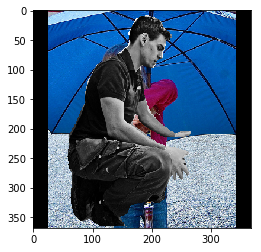

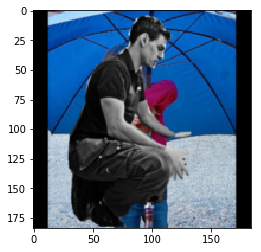

In [2]:
EXAMPLES_DIR = 'D:/Research/LayeredEmbeddings/val_set'
with open(os.path.join(EXAMPLES_DIR, 'example_000000009448_and_000000003156_full.pickle'), 'rb') as file:
    example = pickle.load(file)
image = example['image_scaled_and_padded'].astype(np.uint8)

plt.imshow(image.astype(np.uint8))
plt.show()

lr = cv2.pyrDown(image)
plt.imshow(lr)
plt.show()

In [3]:
vgg19 = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [4]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

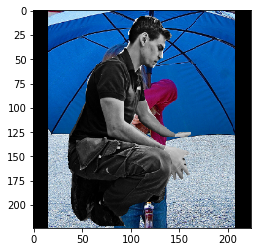

In [5]:
image = cv2.resize(example['image_scaled_and_padded'], (224,224))
plt.imshow(image.astype(np.uint8))
plt.show()

keras_out = vgg19.predict( np.expand_dims(image,0) )



In [7]:
graph = K.get_session().graph

sess = K.get_session()
#    sess.run(tf.global_variables_initializer())
out = graph.get_tensor_by_name('predictions/Softmax:0')
tf_out = sess.run( out, feed_dict={'input_1:0': np.expand_dims(image,0) })

In [ ]:
i = keras.layers.Input((64,64,3))
out = keras.layers.Conv2D(3, (3,3))(i)

In [14]:
for tensor in tf.contrib.graph_editor.get_tensors(graph):
    print(tensor)

Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("block1_conv1/random_uniform/shape:0", shape=(4,), dtype=int32)
Tensor("block1_conv1/random_uniform/min:0", shape=(), dtype=float32)
Tensor("block1_conv1/random_uniform/max:0", shape=(), dtype=float32)
Tensor("block1_conv1/random_uniform/RandomUniform:0", shape=(3, 3, 3, 64), dtype=float32)
Tensor("block1_conv1/random_uniform/sub:0", shape=(), dtype=float32)
Tensor("block1_conv1/random_uniform/mul:0", shape=(3, 3, 3, 64), dtype=float32)
Tensor("block1_conv1/random_uniform:0", shape=(3, 3, 3, 64), dtype=float32)
Tensor("block1_conv1/kernel:0", shape=(3, 3, 3, 64), dtype=float32_ref)
Tensor("block1_conv1/kernel/Assign:0", shape=(3, 3, 3, 64), dtype=float32_ref)
Tensor("block1_conv1/kernel/read:0", shape=(3, 3, 3, 64), dtype=float32)
Tensor("block1_conv1/Const:0", shape=(64,), dtype=float32)
Tensor("block1_conv1/bias:0", shape=(64,), dtype=float32_ref)
Tensor("block1_conv1/bias/Assign:0", shape=(64,), dtype=float32_ref)
Ten

Tensor("import/block3_conv1/kernel/Assign:0", shape=(3, 3, 128, 256), dtype=float32_ref)
Tensor("import/block2_conv2/convolution/dilation_rate:0", shape=(2,), dtype=int32)
Tensor("import/block2_conv2/bias:0", shape=(128,), dtype=float32_ref)
Tensor("import/IsVariableInitialized_7:0", shape=(), dtype=bool)
Tensor("import/Assign_7:0", shape=(128,), dtype=float32_ref)
Tensor("import/block2_conv2/bias/read:0", shape=(128,), dtype=float32)
Tensor("import/block2_conv2/Const:0", shape=(128,), dtype=float32)
Tensor("import/block2_conv2/bias/Assign:0", shape=(128,), dtype=float32_ref)
Tensor("import/block2_conv2/kernel:0", shape=(3, 3, 128, 128), dtype=float32_ref)
Tensor("import/IsVariableInitialized_6:0", shape=(), dtype=bool)
Tensor("import/Assign_6:0", shape=(3, 3, 128, 128), dtype=float32_ref)
Tensor("import/block2_conv2/kernel/read:0", shape=(3, 3, 128, 128), dtype=float32)
Tensor("import/block2_conv2/random_uniform/max:0", shape=(), dtype=float32)
Tensor("import/block2_conv2/random_unifo

In [ ]:
print(tf_out-keras_out)


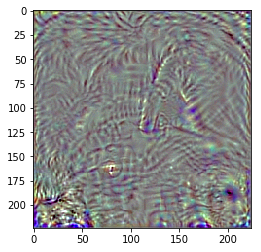

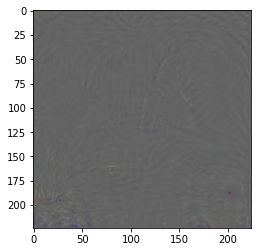

In [56]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'predictions/Softmax:0'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
#img_noise = np.expand_dims(image,0) + np.random.uniform(0,1,(224,224,3))
img_noise = np.random.uniform(0,1,(1,224,224,3)) + 100
t_input = graph.get_tensor_by_name('input_1:0')

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a[0])
    plt.show()
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=0.5):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    print(t_score)
    print(t_grad)
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))
    return img[0]

sess = K.get_session()
img = render_naive(T(layer)[:,341], iter_n=2048)
plt.imshow(np.clip(img,0,255).astype(np.uint8))
plt.show()


In [48]:
out = vgg19.predict( np.expand_dims(np.clip(img,0,255),0) )

In [49]:
print(np.argmax(out))

341


In [51]:
cv2.imwrite('classify.png', cv2.cvtColor(np.clip(img,0,255).astype(np.uint8), cv2.COLOR_RGB2BGR))

True

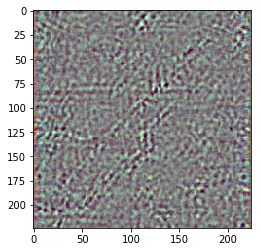

InvalidArgumentError: input must be 4-dimensional[1,1,224,224,3]
	 [[Node: ResizeBilinear_29 = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](ExpandDims_48, _arg_Placeholder_105_0_1/_1653)]]
	 [[Node: strided_slice_88/_1655 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17_strided_slice_88", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'ResizeBilinear_29', defined at:
  File "c:\anaconda\envs\ml\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\anaconda\envs\ml\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\anaconda\envs\ml\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\anaconda\envs\ml\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\anaconda\envs\ml\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\anaconda\envs\ml\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\anaconda\envs\ml\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\anaconda\envs\ml\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\anaconda\envs\ml\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\anaconda\envs\ml\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\anaconda\envs\ml\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\anaconda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\anaconda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\anaconda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-122-b7830aa8658f>", line 17, in <module>
    resize = tffunc(np.float32, np.int32)(resize)
  File "<ipython-input-122-b7830aa8658f>", line 7, in wrap
    out = f(*placeholders)
  File "<ipython-input-122-b7830aa8658f>", line 16, in resize
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
  File "c:\anaconda\envs\ml\lib\site-packages\tensorflow\python\ops\gen_image_ops.py", line 2656, in resize_bilinear
    align_corners=align_corners, name=name)
  File "c:\anaconda\envs\ml\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\anaconda\envs\ml\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "c:\anaconda\envs\ml\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): input must be 4-dimensional[1,1,224,224,3]
	 [[Node: ResizeBilinear_29 = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](ExpandDims_48, _arg_Placeholder_105_0_1/_1653)]]
	 [[Node: strided_slice_88/_1655 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17_strided_slice_88", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [122]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=sess)
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=224):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[1:3]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 2), sy, 1)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[0:1,y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 1)

def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=2, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[1:3])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))
    return img[0]
        
img_noise = np.random.uniform(0,1,(1,224,224,3)) + 100
sess = K.get_session()    
img = render_multiscale(T(layer)[:,341])        

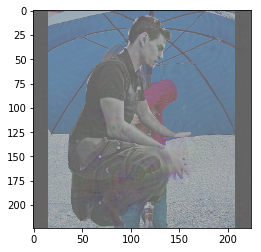

ValueError: Cannot feed value of shape (1, 1, 313, 3) for Tensor 'input_1:0', which has shape '(?, 224, 224, 3)'

In [148]:
k = np.float64([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)



def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
#    img = tf.expand_dims(img,0)
#    print(img)
    tlevels = lap_split_n(img, scale_n)
    tlevels = [ normalize_std(level) for level in tlevels ]
    out = lap_merge(tlevels)
    return out
#    return out[0,:,:,:]    
    
image_in = tf.expand_dims(image,0)

levels = sess.run(lap_split_n(image_in, 3))
merged = sess.run( lap_merge(levels) )

plt.imshow(merged[0].astype(np.uint8))
plt.show()

for level in levels:
    plt.imshow(level[0].astype(np.uint8))
    plt.show()

    
    
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=2, octave_scale=1.4, lap_n=400):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float64)(lap_normalize)

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
#            g = calc_grad_tiled(img, t_grad)
            g = sess.run(t_grad, {t_input:img})
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,341], img0 = np.expand_dims(image,0))

(224, 224)

In [153]:
# Helper function that uses TF to resize an image
def resize(img, size):
    return tf.image.resize_bilinear(img, size)
resize = tffunc(np.float32, np.int32)(resize)


out = sess.run( resize(image_in, [32,32]) )

TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, numpy ndarrays, or TensorHandles.For reference, the tensor object was Tensor("ExpandDims_86:0", shape=(1, 224, 224, 3), dtype=float64) which was passed to the feed with key Tensor("Placeholder_137:0", dtype=float32).